In [ ]:
#Installs 
!pip install torch 
!pip install transformers datasets
!pip install vaderSentiment
!pip install spacy
!python -m spacy download en_core_web_sm


# Imports 

In [1]:
# Standard Libraries
import os
import re
import string
from collections import Counter

# Data Handling
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import ngrams

# Text Processing
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy 

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Feature Engineering & NLP
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2

# Machine Learning Models
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel, AutoTokenizer

# Dataset Management
from datasets import Dataset, DatasetDict
from sklearn.feature_extraction.text import TfidfVectorizer


# Utility
print(os.getcwd())  # Check current directory
import torch

/Users/karhin/Desktop/NYT_emotion/notebooks


# Reading In Data 

In [4]:
#Reading in data
df = pd.read_json("../data/homework.json", lines=True)


df.head()

,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,emotion_9,headline,summary,worker_id
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,Parenting Lessons From a Partial Eclipse,I don’t do partiality. Maybe it was finally ti...,95524929
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,On Catalonia,Catalan lawmakers declared independence from S...,30266977
2,0.0,0.0,-2,0.0,0.0,0.0,0.0,0.0,0.0,1,A Spark of Romance Under Fluorescent Lighting,"Rose Burlingham, an art dealer and writer, mar...",54197764
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1,Apple Removes Apps From China Store That Help ...,The world’s most valuable company appears to h...,41177265
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,Commerce Secretary’s Offshore Ties to Putin ‘C...,"Wilbur Ross, the commerce secretary, retained ...",56518865


# Data Cleaning 

In [7]:
# Unique values in each emotion column
emotion_cols = [col for col in df.columns if 'emotion_' in col]
for col in emotion_cols:
    print(f"{col}: {df[col].unique()}")


emotion_0: ['0.0' '1.0' 'cat' 'fnord' '-1' None '-2']
emotion_1: ['0.0' '1.0' 'cat' None 'fnord' '-1' '-2']
emotion_2: ['0.0' '-2' '1.0' 'cat' 'fnord' '-1' None]
emotion_3: ['0.0' '1.0' '-2' 'fnord' 'cat' '-1' None]
emotion_4: ['0.0' '1.0' 'fnord' '-1' 'cat' '-2' None]
emotion_5: ['1.0' '0.0' None '-1' 'fnord' '-2' 'cat']
emotion_6: ['0.0' '1.0' None '-2' 'fnord' 'cat' '-1']
emotion_7: ['0.0' '1.0' 'cat' '-2' 'fnord' None '-1']
emotion_8: ['0.0' '1.0' None 'fnord' '-2' '-1' 'cat']
emotion_9: ['1' 'cat' None 'fnord' '-2' '-1']


In [9]:
# Check for missing values
print(df.isnull().sum())


emotion_0    190
emotion_1    184
emotion_2    154
emotion_3    157
emotion_4    191
emotion_5    203
emotion_6    199
emotion_7    185
emotion_8    193
emotion_9    172
headline       0
summary        0
worker_id    192
dtype: int64


# Looking at Emotion

In [12]:
df.emotion_1.value_counts()

emotion_1
0.0      85818
1.0       8977
-1         204
-2         200
cat        191
fnord      186
Name: count, dtype: int64

In [14]:
df.emotion_2.value_counts()

emotion_2
0.0      87311
1.0       7512
-1         213
fnord      196
cat        188
-2         186
Name: count, dtype: int64

In [16]:
df.emotion_3.value_counts()

emotion_3
0.0      87695
1.0       7131
fnord      210
-2         197
-1         193
cat        177
Name: count, dtype: int64

In [18]:
df.emotion_4.value_counts()

emotion_4
0.0      85400
1.0       9403
-2         201
cat        196
fnord      188
-1         181
Name: count, dtype: int64

In [20]:
df.emotion_5.value_counts()

emotion_5
0.0      58192
1.0      36572
-1         203
-2         202
cat        197
fnord      191
Name: count, dtype: int64

In [22]:
df.emotion_6.value_counts()

emotion_6
0.0      91334
1.0       3509
fnord      197
-2         184
cat        170
-1         167
Name: count, dtype: int64

In [24]:
df.emotion_7.value_counts()

emotion_7
0.0      78226
1.0      16568
cat        204
fnord      196
-1         193
-2         188
Name: count, dtype: int64

In [26]:
df.emotion_8.value_counts()

emotion_8
0.0      73435
1.0      21388
-2         188
-1         186
cat        186
fnord      184
Name: count, dtype: int64

In [28]:
df.emotion_9.value_counts()

emotion_9
1        94832
fnord      214
-1         192
cat        179
-2         171
Name: count, dtype: int64

## Making some cuts based on intial analyiss

In [31]:
df = df.replace(["-1", "fnord", "-2", "cat"], None)

In [33]:
df = df.dropna()

In [35]:
#Double checking to make sure that it was done properly 
df.isna().sum()

emotion_0    0
emotion_1    0
emotion_2    0
emotion_3    0
emotion_4    0
emotion_5    0
emotion_6    0
emotion_7    0
emotion_8    0
emotion_9    0
headline     0
summary      0
worker_id    0
dtype: int64

In [37]:
df.shape

(84515, 13)

In [39]:
# Define emotion columns
emotion_cols = [col for col in df.columns if 'emotion_' in col]

# Function to clean the emotion values
def clean_emotion(value):
    if value in ['1.0', 1, '1']:
        return 1
    elif value in ['0.0', 0, '0']:
        return 0
    else:
        return 0  # or np.nan if you'd rather mark as missing

# Apply the cleaning function to each emotion column
for col in emotion_cols:
    df[col] = df[col].map(clean_emotion)

# Verify cleaned data
for col in emotion_cols:
    print(f"{col}: {df[col].unique()}")


emotion_0: [0 1]
emotion_1: [0 1]
emotion_2: [0 1]
emotion_3: [0 1]
emotion_4: [0 1]
emotion_5: [1 0]
emotion_6: [0 1]
emotion_7: [0 1]
emotion_8: [0 1]
emotion_9: [1]


In [41]:
print(df['emotion_9'].value_counts())


emotion_9
1    84515
Name: count, dtype: int64


In [43]:
#dropping emotion 9 column because it is all the same 

df = df.drop(columns=['emotion_9'])



In [45]:
emotion_cols.remove('emotion_9')

In [47]:
df.head()

,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,headline,summary,worker_id
0,0,0,0,0,0,1,0,0,0,Parenting Lessons From a Partial Eclipse,I don’t do partiality. Maybe it was finally ti...,95524929
1,0,0,0,0,0,1,0,0,0,On Catalonia,Catalan lawmakers declared independence from S...,30266977
3,0,1,0,1,0,1,0,1,0,Apple Removes Apps From China Store That Help ...,The world’s most valuable company appears to h...,41177265
4,0,0,0,0,0,1,0,0,0,Commerce Secretary’s Offshore Ties to Putin ‘C...,"Wilbur Ross, the commerce secretary, retained ...",56518865
5,0,0,0,0,0,0,0,0,1,"Battered and Scarred, ‘Sphere’ Returns to 9/11...",Though the sculpture emerged from the smolderi...,50816171


## Looking at the text data 

In [50]:
print(df[['headline', 'summary']].isnull().sum())


headline    0
summary     0
dtype: int64


In [52]:
print((df['headline'].str.strip() == '').sum())
print((df['summary'].str.strip() == '').sum())


166
155


In [54]:
# Drop rows where either headline or summary is empty
df = df[~(df['headline'].str.strip() == '')]
df = df[~(df['summary'].str.strip() == '')]

# Reset index after dropping
df.reset_index(drop=True, inplace=True)

print(f"Remaining rows after dropping empty text: {df.shape[0]}")


Remaining rows after dropping empty text: 84194


In [60]:
df['headline_length'] = df['headline'].apply(lambda x: len(str(x).split()))
df['summary_length'] = df['summary'].apply(lambda x: len(str(x).split()))

print(df[['headline_length', 'summary_length']].describe())

       headline_length  summary_length
count     84194.000000    84194.000000
mean          9.063876       21.724588
std           2.545869        5.560048
min           1.000000        1.000000
25%           8.000000       19.000000
50%           9.000000       22.000000
75%          11.000000       25.000000
max          20.000000       47.000000


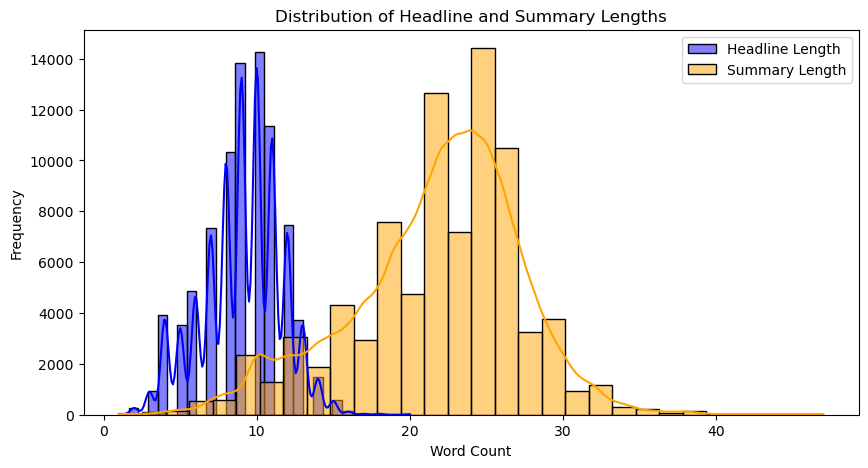

In [62]:
plt.figure(figsize=(10, 5))
sns.histplot(df['headline_length'], bins=30, color='blue', kde=True, label='Headline Length')
sns.histplot(df['summary_length'], bins=30, color='orange', kde=True, label='Summary Length')
plt.legend()
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Headline and Summary Lengths')
plt.show()


In [64]:
# combining headline and summary 
df['text'] = df['headline'].astype(str) + " " + df['summary'].astype(str)


In [70]:
df.head()

,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,headline,summary,worker_id,headline_length,summary_length,text
0,0,0,0,0,0,1,0,0,0,Parenting Lessons From a Partial Eclipse,I don’t do partiality. Maybe it was finally ti...,95524929,6,11,Parenting Lessons From a Partial Eclipse I don...
1,0,0,0,0,0,1,0,0,0,On Catalonia,Catalan lawmakers declared independence from S...,30266977,2,8,On Catalonia Catalan lawmakers declared indepe...
2,0,1,0,1,0,1,0,1,0,Apple Removes Apps From China Store That Help ...,The world’s most valuable company appears to h...,41177265,12,22,Apple Removes Apps From China Store That Help ...
3,0,0,0,0,0,1,0,0,0,Commerce Secretary’s Offshore Ties to Putin ‘C...,"Wilbur Ross, the commerce secretary, retained ...",56518865,7,22,Commerce Secretary’s Offshore Ties to Putin ‘C...
4,0,0,0,0,0,0,0,0,1,"Battered and Scarred, ‘Sphere’ Returns to 9/11...",Though the sculpture emerged from the smolderi...,50816171,8,24,"Battered and Scarred, ‘Sphere’ Returns to 9/11..."


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84194 entries, 0 to 84193
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   emotion_0          84194 non-null  int64  
 1   emotion_1          84194 non-null  int64  
 2   emotion_2          84194 non-null  int64  
 3   emotion_3          84194 non-null  int64  
 4   emotion_4          84194 non-null  int64  
 5   emotion_5          84194 non-null  int64  
 6   emotion_6          84194 non-null  int64  
 7   emotion_7          84194 non-null  int64  
 8   emotion_8          84194 non-null  int64  
 9   headline           84194 non-null  object 
 10  summary            84194 non-null  object 
 11  headline_length    84194 non-null  int64  
 12  summary_length     84194 non-null  int64  
 13  text               84194 non-null  object 
 14  clean_headline     84194 non-null  object 
 15  clean_summary      84194 non-null  object 
 16  clean_text         841

In [68]:
print(df.columns)
print(emotion_cols)


Index(['emotion_0', 'emotion_1', 'emotion_2', 'emotion_3', 'emotion_4',
       'emotion_5', 'emotion_6', 'emotion_7', 'emotion_8', 'headline',
       'summary', 'worker_id', 'headline_length', 'summary_length', 'text'],
      dtype='object')
['emotion_0', 'emotion_1', 'emotion_2', 'emotion_3', 'emotion_4', 'emotion_5', 'emotion_6', 'emotion_7', 'emotion_8']


In [72]:
df.drop(columns=['worker_id'], inplace=True)

In [76]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # Lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

# Apply cleaning
df['clean_headline'] = df['headline'].apply(clean_text)
df['clean_summary'] = df['summary'].apply(clean_text)
# Apply cleaning to text column
df['clean_text'] = df['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/karhin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [133]:
df.drop(columns=['headline','summary','text'],inplace=True)

In [135]:
# Combine all headlines/summaries into one string
headline_words = ' '.join(df['clean_headline']).split()
summary_words = ' '.join(df['clean_summary']).split()

# Count most common words
headline_common = Counter(headline_words).most_common(20)
summary_common = Counter(summary_words).most_common(20)

print("Top 20 Words in Headlines:", headline_common)
print("Top 20 Words in Summaries:", summary_common)


Top 20 Words in Headlines: [('new', 6175), ('trump', 6062), ('tax', 2604), ('york', 2547), ('north', 2390), ('us', 2337), ('says', 2142), ('korea', 2060), ('review', 1736), ('health', 1570), ('trump’s', 1522), ('today', 1333), ('one', 1305), ('bill', 1292), ('briefing', 1188), ('city', 1188), ('puerto', 1186), ('‘the', 1171), ('dies', 1151), ('world', 1131)]
Top 20 Words in Summaries: [('new', 9783), ('president', 6849), ('said', 5702), ('trump', 4569), ('one', 4140), ('mr', 3938), ('—', 3921), ('first', 3388), ('york', 3180), ('would', 3155), ('two', 3027), ('people', 2886), ('city', 2740), ('could', 2636), ('tax', 2595), ('years', 2485), ('met', 2376), ('like', 2365), ('many', 2227), ('state', 2149)]


In [137]:
# Capture unigrams, bigrams, and trigrams
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 2),  # (min_n, max_n)
    max_features=5000
)
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])


In [138]:
# For TF-IDF
feature_names = tfidf_vectorizer.get_feature_names_out()
sums = X_tfidf.sum(axis=0)  # Sum the TF-IDF scores per column
ranked_indices = sums.argsort()[::-1]  # Sort descending

top_n = 20
for i in range(top_n):
    idx = ranked_indices[0, i]
    print(feature_names[idx], sums[0, idx])


think interesting 13.337408982946707
movies new 14.421815747941713
mr kelly 15.17778572713001
mr franken 15.355585307862412
new details 15.486214611094251
wells fargo 15.727308555990744
fargo 15.727308555990744
public schools 15.800133827914978
colleague 15.887293279985753
mr meyers 15.97163500264742
jim mattis 15.980983338968013
signature 16.051449669684164
citi field 16.078842531914255
sailors 16.191110750141778
updates analysis 16.212495973815994
initially 16.232792232748732
trek discovery 16.38858778726993
places like 16.43802606571085
west coast 16.45364233573912
streaming service 16.4623360924067


# Word Clouds

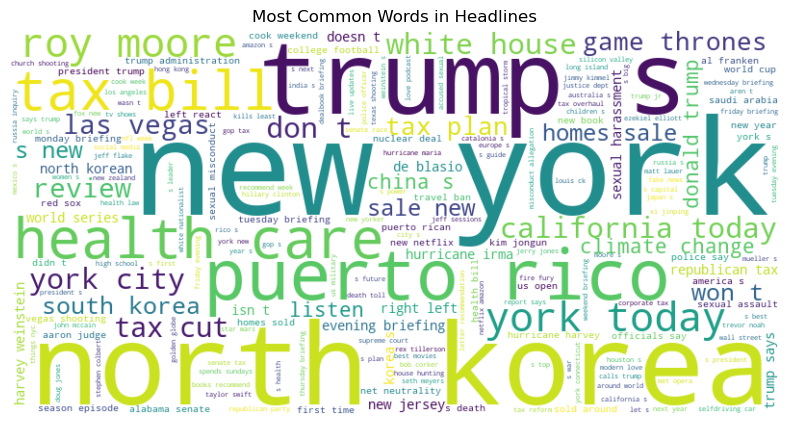

In [142]:
# Generate word cloud for headlines
headline_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(headline_words))

plt.figure(figsize=(10, 5))
plt.imshow(headline_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Headlines')
plt.show()


## Word clouds by emotion 

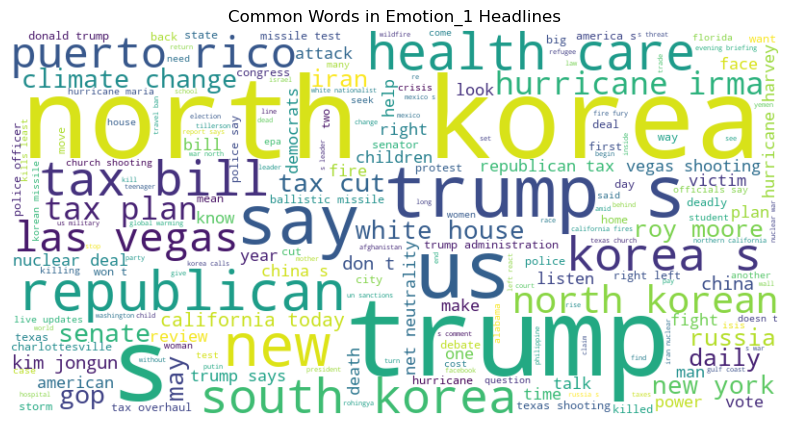

In [144]:
# Check for keywords in articles labeled with specific emotions
emotion_sample = df[df['emotion_1'] == 1]  # Example for emotion_1
emotion_text = ' '.join(emotion_sample['clean_headline'])

emotion_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(emotion_text)

plt.figure(figsize=(10, 5))
plt.imshow(emotion_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Emotion_1 Headlines')
plt.show()


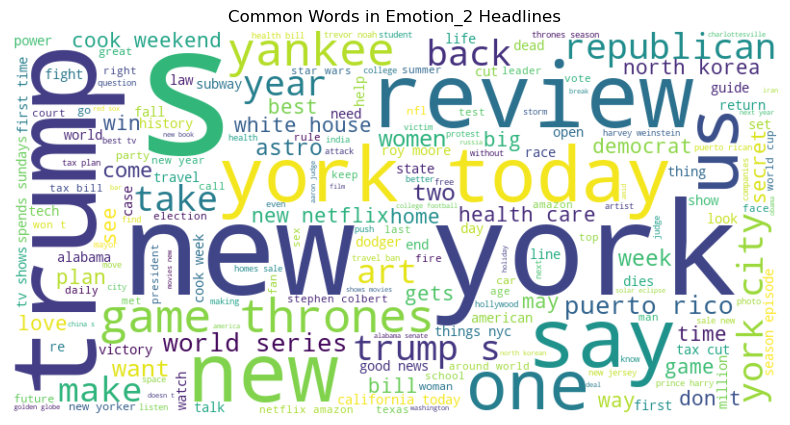

In [146]:
# Check for keywords in articles labeled with specific emotions
emotion_sample = df[df['emotion_2'] == 1] 
emotion_text = ' '.join(emotion_sample['clean_headline'])

emotion_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(emotion_text)

plt.figure(figsize=(10, 5))
plt.imshow(emotion_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Emotion_2 Headlines')
plt.show()


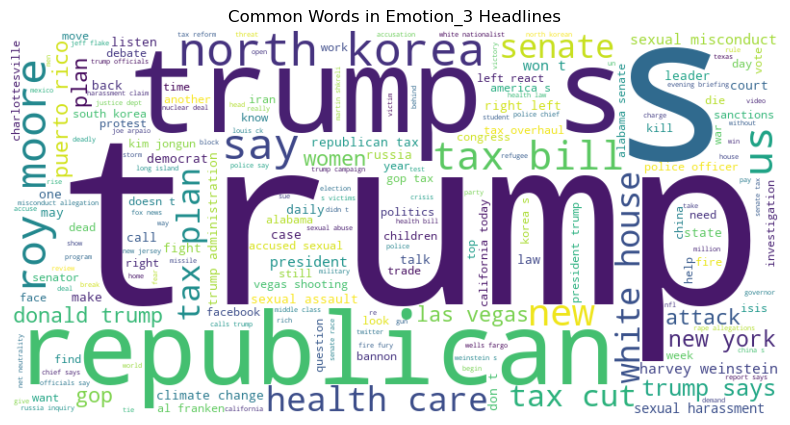

In [148]:
# Check for keywords in articles labeled with specific emotions
emotion_sample = df[df['emotion_3'] == 1] 
emotion_text = ' '.join(emotion_sample['clean_headline'])

emotion_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(emotion_text)

plt.figure(figsize=(10, 5))
plt.imshow(emotion_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Emotion_3 Headlines')
plt.show()


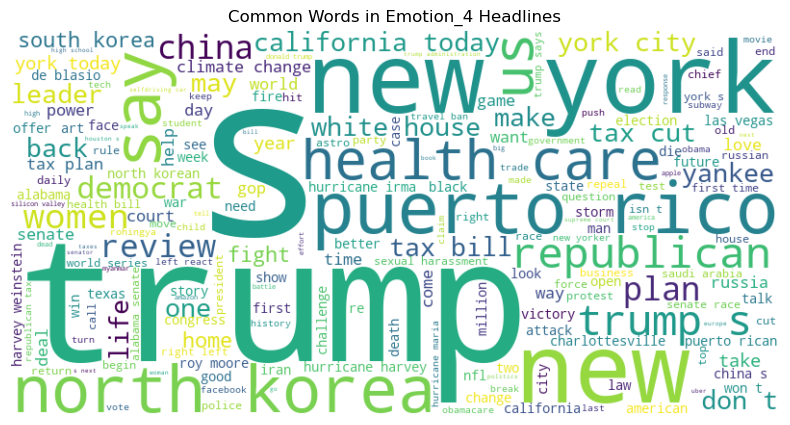

In [150]:
# Check for keywords in articles labeled with specific emotions
emotion_sample = df[df['emotion_4'] == 1] 
emotion_text = ' '.join(emotion_sample['clean_headline'])

emotion_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(emotion_text)

plt.figure(figsize=(10, 5))
plt.imshow(emotion_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Emotion_4 Headlines')
plt.show()


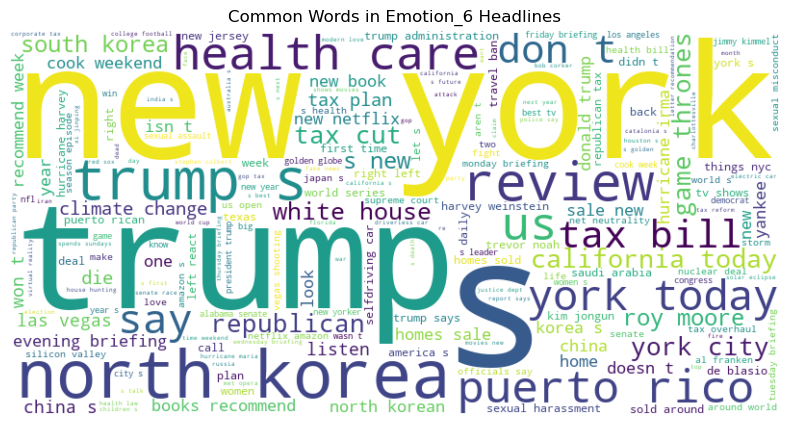

In [152]:
# Check for keywords in articles labeled with specific emotions
emotion_sample = df[df['emotion_5'] == 1] 
emotion_text = ' '.join(emotion_sample['clean_headline'])

emotion_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(emotion_text)

plt.figure(figsize=(10, 5))
plt.imshow(emotion_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Emotion_6 Headlines')
plt.show()


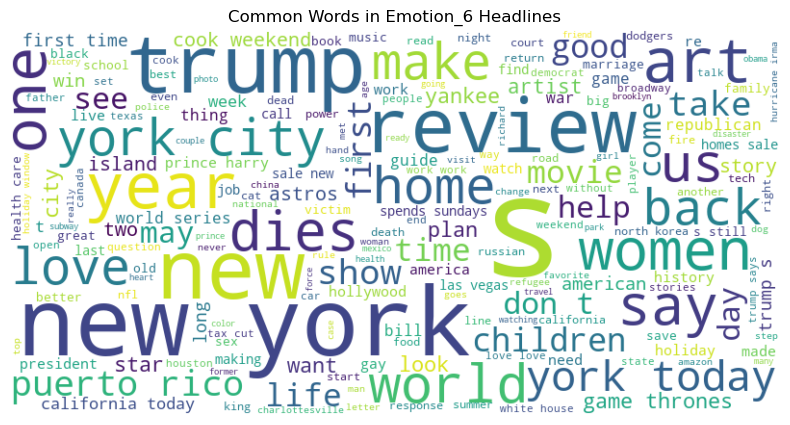

In [154]:
# Check for keywords in articles labeled with specific emotions
emotion_sample = df[df['emotion_6'] == 1] 
emotion_text = ' '.join(emotion_sample['clean_headline'])

emotion_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(emotion_text)

plt.figure(figsize=(10, 5))
plt.imshow(emotion_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Emotion_6 Headlines')
plt.show()


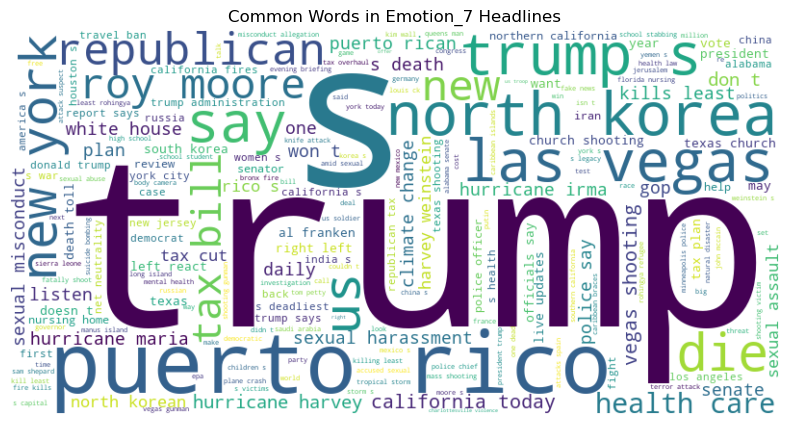

In [155]:
# Check for keywords in articles labeled with specific emotions
emotion_sample = df[df['emotion_7'] == 1] 
emotion_text = ' '.join(emotion_sample['clean_headline'])

emotion_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(emotion_text)

plt.figure(figsize=(10, 5))
plt.imshow(emotion_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Emotion_7 Headlines')
plt.show()


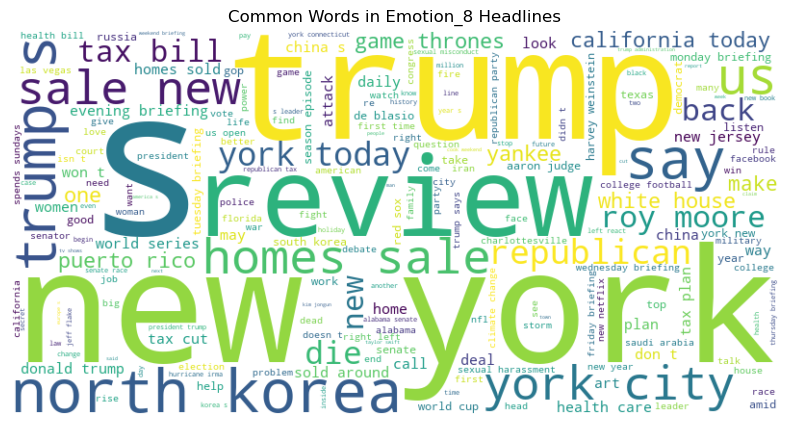

In [157]:
# Check for keywords in articles labeled with specific emotions
emotion_sample = df[df['emotion_8'] == 1] 
emotion_text = ' '.join(emotion_sample['clean_headline'])

emotion_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(emotion_text)

plt.figure(figsize=(10, 5))
plt.imshow(emotion_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Emotion_8 Headlines')
plt.show()


In [161]:
# Tokenize text
df['tokens'] = df['clean_text'].apply(lambda x: re.findall(r'\w+', x.lower()))

# Train Word2Vec model
w2v_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=2, workers=4)

# Create Word2Vec embeddings
def get_w2v_vector(tokens, model):
    return np.mean([model.wv[word] for word in tokens if word in model.wv] or [np.zeros(100)], axis=0)

df['w2v_embedding'] = df['tokens'].apply(lambda x: get_w2v_vector(x, w2v_model))


In [163]:
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
df['char_count'] = df['clean_text'].apply(len)
df['unique_word_ratio'] = df['clean_text'].apply(lambda x: len(set(x.split())) / len(x.split()))


In [167]:
# Initialize the VADER sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment scores for each text entry
def get_sentiment_scores(text):
    sentiment = vader_analyzer.polarity_scores(text)
    return sentiment['compound']

# Apply sentiment analysis to the cleaned text column
df['sentiment_score'] = df['clean_text'].apply(get_sentiment_scores)


emotion_6     3148
emotion_3     6329
emotion_2     6670
emotion_1     7924
emotion_0     8150
emotion_4     8324
emotion_7    14686
emotion_8    18992
emotion_5    32451
dtype: int64


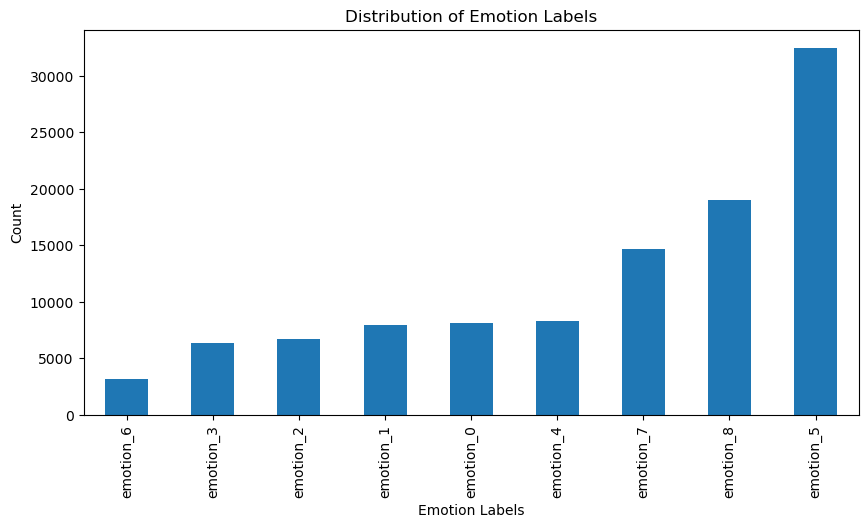

In [123]:
# Count the occurrences of each emotion label
emotion_columns = [col for col in df.columns if col.startswith('emotion_')]
emotion_counts = df[emotion_columns].sum().sort_values()

# Print class distribution
print(emotion_counts)

# Plot the distribution
plt.figure(figsize=(10, 5))
emotion_counts.plot(kind='bar')
plt.title('Distribution of Emotion Labels')
plt.xlabel('Emotion Labels')
plt.ylabel('Count')
plt.show()


emotion_6     3.738984
emotion_3     7.517163
emotion_2     7.922180
emotion_1     9.411597
emotion_0     9.680025
emotion_4     9.886690
emotion_7    17.443048
emotion_8    22.557427
emotion_5    38.543127
dtype: float64


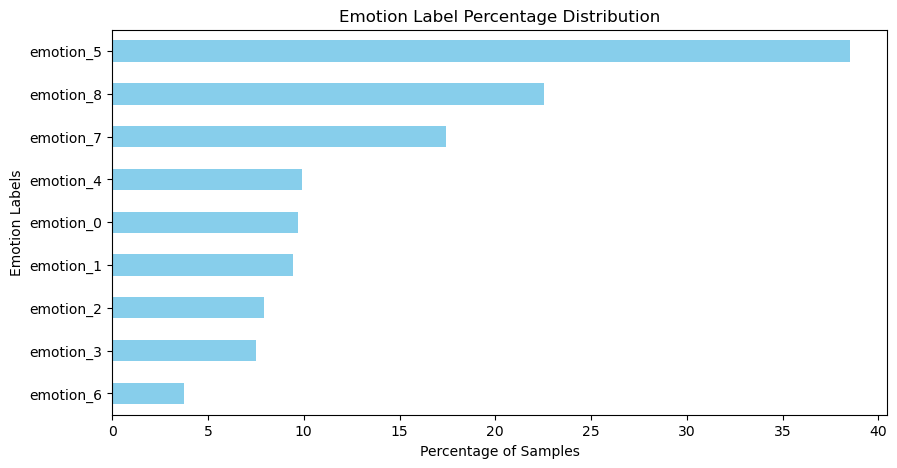

In [125]:
emotion_percentages = (df[emotion_columns].sum() / len(df)) * 100
print(emotion_percentages.sort_values())

# Visualize
plt.figure(figsize=(10, 5))
emotion_percentages.sort_values().plot(kind='barh', color='skyblue')
plt.title('Emotion Label Percentage Distribution')
plt.xlabel('Percentage of Samples')
plt.ylabel('Emotion Labels')
plt.show()


In [175]:
vectorizer = CountVectorizer(
    stop_words='english',   # or a custom stopword list
    ngram_range=(2, 2),     # bigrams only
    min_df=2                # only consider bigrams appearing at least twice
)

for emotion in emotion_cols:
    sub_df = df[df[emotion] == 1]
    text_data = sub_df['clean_text'].astype(str).tolist()
    
    # Fit the vectorizer on the text for this emotion
    X = vectorizer.fit_transform(text_data)
    
    # Sum up the counts of each bigram
    bigram_freq = X.sum(axis=0).A1  # Convert to 1D array
    indices = bigram_freq.argsort()[::-1]  # sort descending
    
    # Map bigram -> frequency
    vocab = vectorizer.get_feature_names_out()
    
    print(f"Emotion: {emotion}")
    for idx in indices[:20]:
        print(f"   {vocab[idx]} -> {bigram_freq[idx]}")
    print("\n---\n")


Emotion: emotion_0
   new york -> 697
   president trump -> 405
   couple met -> 198
   white house -> 197
   north korea -> 159
   need know -> 142
   world series -> 141
   york city -> 136
   briefing need -> 131
   health care -> 118
   roy moore -> 118
   united states -> 103
   game thrones -> 103
   know start -> 88
   start day -> 88
   york today -> 85
   donald trump -> 84
   york times -> 67
   sexual misconduct -> 63
   trump administration -> 63

---

Emotion: emotion_1
   north korea -> 1105
   president trump -> 539
   united states -> 317
   health care -> 209
   south korea -> 200
   north korean -> 178
   trump administration -> 174
   new york -> 168
   kim jongun -> 164
   white house -> 159
   puerto rico -> 152
   climate change -> 134
   las vegas -> 134
   hurricane irma -> 126
   tax plan -> 99
   need know -> 94
   roy moore -> 93
   mr trump -> 92
   police said -> 85
   nuclear deal -> 81

---

Emotion: emotion_2
   new york -> 719
   couple met -> 388
   pr

# Feature Importance Analysis Using Chi-Square Test

In [127]:
vectorizer = CountVectorizer(
    stop_words='english',
    ngram_range=(2, 3),
    min_df=2  # or any threshold you like
)
X = vectorizer.fit_transform(df['clean_text'])  # shape: (N, M)
feature_names = vectorizer.get_feature_names_out()

emotion_cols = [col for col in df.columns if 'emotion_' in col]

for emotion in emotion_cols:
    y = df[emotion]  # 0/1 labels for the specific emotion
    
    # chi2 scores and p-values
    chi2_scores, p_values = chi2(X, y)
    
    # Pair up (feature_name, chi2_score, p_value)
    chi2_with_names = list(zip(feature_names, chi2_scores, p_values))
    
    # Sort by chi-square in descending order
    chi2_with_names.sort(key=lambda x: x[1], reverse=True)
    
    print(f"=== {emotion} ===")
    # Show top 10 bigrams most strongly correlated with 'emotion'
    for i in range(10):
        feat, score, pval = chi2_with_names[i]
        print(f"{feat} -> chi2={score:.2f}, p={pval:.3g}")
    print()


=== emotion_0 ===
world series -> chi2=144.29, p=3.07e-33
aaron judge -> chi2=76.41, p=2.31e-18
north korea -> chi2=73.36, p=1.08e-17
pga championship -> chi2=72.85, p=1.4e-17
home run -> chi2=70.73, p=4.09e-17
star trek -> chi2=58.71, p=1.82e-14
puerto rico -> chi2=58.55, p=1.99e-14
home runs -> chi2=55.73, p=8.33e-14
football game -> chi2=54.51, p=1.55e-13
wildcard game -> chi2=53.42, p=2.7e-13

=== emotion_1 ===
north korea -> chi2=2503.69, p=0
kim jongun -> chi2=434.36, p=1.83e-96
missile test -> chi2=401.93, p=2.09e-89
north korean -> chi2=346.66, p=2.26e-77
new york -> chi2=320.54, p=1.11e-71
south korea -> chi2=276.97, p=3.43e-62
united states -> chi2=224.70, p=8.55e-51
ballistic missile -> chi2=218.32, p=2.11e-49
tensions north korea -> chi2=204.44, p=2.24e-46
nuclear deal -> chi2=185.16, p=3.63e-42

=== emotion_2 ===
couple met -> chi2=779.49, p=1.55e-171
met years -> chi2=140.94, p=1.66e-32
met years ago -> chi2=140.94, p=1.66e-32
north korea -> chi2=137.82, p=7.98e-32
new yo

# Final Dataset

In [171]:
df.head()

,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,headline_length,summary_length,clean_headline,clean_summary,clean_text,tokens,w2v_embedding,word_count,char_count,unique_word_ratio,sentiment_score
0,0,0,0,0,0,1,0,0,0,6,11,parenting lessons partial eclipse,don’t partiality maybe finally time try,parenting lessons partial eclipse don’t partia...,"[parenting, lessons, partial, eclipse, don, t,...","[0.2789099, 0.35104534, 0.5521695, 0.72913414,...",10,73,1.000000,0.0000
1,0,0,0,0,0,1,0,0,0,2,8,catalonia,catalan lawmakers declared independence spain ...,catalonia catalan lawmakers declared independe...,"[catalonia, catalan, lawmakers, declared, inde...","[-0.68591917, 0.86837965, -0.2718815, -0.60979...",7,62,1.000000,0.0000
2,0,1,0,1,0,1,0,1,0,12,22,apple removes apps china store help internet u...,world’s valuable company appears pulled apps a...,apple removes apps china store help internet u...,"[apple, removes, apps, china, store, help, int...","[-0.7135026, 0.37232846, 0.7488899, 0.58045423...",24,175,0.875000,0.7003
3,0,0,0,0,0,1,0,0,0,7,22,commerce secretary’s offshore ties putin ‘cron...,wilbur ross commerce secretary retained invest...,commerce secretary’s offshore ties putin ‘cron...,"[commerce, secretary, s, offshore, ties, putin...","[-0.08289998, 0.58358634, 0.18865892, -0.00436...",23,180,0.913043,0.0258
4,0,0,0,0,0,0,0,0,1,8,24,battered scarred ‘sphere’ returns 911 site,though sculpture emerged smoldering ruins larg...,battered scarred ‘sphere’ returns 911 site tho...,"[battered, scarred, sphere, returns, 911, site...","[0.10605408, 0.22822355, 0.020637412, 0.246064...",19,149,1.000000,-0.5859


In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84194 entries, 0 to 84193
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   emotion_0          84194 non-null  int64  
 1   emotion_1          84194 non-null  int64  
 2   emotion_2          84194 non-null  int64  
 3   emotion_3          84194 non-null  int64  
 4   emotion_4          84194 non-null  int64  
 5   emotion_5          84194 non-null  int64  
 6   emotion_6          84194 non-null  int64  
 7   emotion_7          84194 non-null  int64  
 8   emotion_8          84194 non-null  int64  
 9   headline_length    84194 non-null  int64  
 10  summary_length     84194 non-null  int64  
 11  clean_headline     84194 non-null  object 
 12  clean_summary      84194 non-null  object 
 13  clean_text         84194 non-null  object 
 14  tokens             84194 non-null  object 
 15  w2v_embedding      84194 non-null  object 
 16  word_count         841

# Saving Dataset

In [177]:
# Save processed dataset to CSV
df.to_csv('/Users/karhin/Desktop/NYT_emotion/data/processed_dataset.csv', index=False)
print('Dataset saved successfully.')

Dataset saved successfully.
